[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/atmos-cloud-sim-uj/PySDM-examples.git/main?urlpath=lab/tree/PySDM_examples/Yang_et_al_2018/fig_2.ipynb)    
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/atmos-cloud-sim-uj/PySDM-examples/blob/main/PySDM_examples/Yang_et_al_2018/fig_2.ipynb)

#### based on Fig. 2 from Yang et al. 2018 (Atmos. Chem. Phys. 18)  "_Cloud droplet size distribution broadening during diffusional growth: ripening amplified by deactivation and reactivation_"   
https://doi.org/10.5194/acp-18-7313-2018

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install git+https://github.com/atmos-cloud-sim-uj/PySDM-examples.git
    !ldconfig

In [2]:
from PySDM.backends.numba.test_helpers.bdf import patch_core
#from PySDM_examples.SURF_activation.example import Simulation
#from PySDM_examples.SURF_activation.settings import Settings
import PySDM.physics.constants as const
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update({'font.size': 16})
# from PySDM_examples.utils.show_plot import show_plot

In [3]:
import pint
si = pint.UnitRegistry()
si.setup_matplotlib()

In [4]:
from PySDM.backends import CPU                                                  
from PySDM.builder import Builder                                               
from PySDM.dynamics import AmbientThermodynamics                                
from PySDM.dynamics import Condensation                                         
from PySDM.environments import Parcel                                           
from PySDM.physics import formulae as phys                                      
from PySDM.physics.formulae import Formulae                                     
import PySDM.products as PySDM_products 

class Simulation:

    def __init__(self, settings, backend=CPU):
        dt_output = settings.total_time / settings.n_steps  # TODO #334 overwritten in jupyter example
        self.n_substeps = 1  # TODO #334 use condensation substeps
        while (dt_output / self.n_substeps >= settings.dt_max):
            self.n_substeps += 1
        self.formulae = Formulae(condensation_coordinate=settings.coord, saturation_vapour_pressure='AugustRocheMagnus')
        self.bins_edges = self.formulae.trivia.volume(settings.r_bins_edges)
        builder = Builder(backend=backend, n_sd=settings.n_sd, formulae=self.formulae)
        builder.set_environment(Parcel(
            dt=dt_output / self.n_substeps,
            mass_of_dry_air=settings.mass_of_dry_air,
            p0=settings.p0,
            q0=settings.q0,
            T0=settings.T0,
            w=settings.w,
            z0=settings.z0
        ))

        environment = builder.core.environment
        builder.add_dynamic(AmbientThermodynamics())
        condensation = Condensation(
            kappa=settings.kappa,
            adaptive=settings.adaptive,
            rtol_x=settings.rtol_x,
            rtol_thd=settings.rtol_thd,
            dt_cond_range=settings.dt_cond_range
        )
        builder.add_dynamic(condensation)

        products = [
            PySDM_products.ParticlesWetSizeSpectrum(radius_bins_edges=settings.r_bins_edges),
            PySDM_products.CondensationTimestepMin(),
            PySDM_products.CondensationTimestepMax(),
            PySDM_products.ActivatingRate(),
            PySDM_products.DeactivatingRate(),
            PySDM_products.RipeningRate(),
            PySDM_products.PeakSupersaturation()
        ]

        attributes = environment.init_attributes(
            n_in_dv=settings.n,
            kappa=settings.kappa,
            r_dry=settings.r_dry
        )
        
        self.core = builder.build(attributes, products)

        self.n_steps = settings.n_steps

    def save(self, output):
        cell_id = 0
        output["r_bins_values"].append(self.core.products["Particles Wet Size Spectrum"].get())
        volume = self.core.particles['volume'].to_ndarray()
        output["r"].append(self.formulae.trivia.radius(volume=volume))
        output["S"].append(self.core.environment["RH"][cell_id] - 1)
        output["qv"].append(self.core.environment["qv"][cell_id])
        output["T"].append(self.core.environment["T"][cell_id])
        output["p"].append(self.core.environment["p"][cell_id])
        output["z"].append(self.core.environment["z"][cell_id])
        output["t"].append(self.core.environment["t"][cell_id])
        output["dt_cond_max"].append(self.core.products["dt_cond_max"].get()[cell_id].copy())
        output["dt_cond_min"].append(self.core.products["dt_cond_min"].get()[cell_id].copy())
        output['ripening_rate'].append(self.core.products['ripening_rate'].get()[cell_id].copy())
        output['activating_rate'].append(self.core.products['activating_rate'].get()[cell_id].copy())
        output['deactivating_rate'].append(self.core.products['deactivating_rate'].get()[cell_id].copy())
        output['peak_S'].append(self.core.products['S_max'].get()[cell_id].copy())
        
    def run(self):
        output = {"r": [], "S": [], "z": [], "t": [], "qv": [], "T": [], "p": [],
                  "r_bins_values": [], "dt_cond_max": [], "dt_cond_min": [], "ripening_rate": [],
                   "activating_rate": [], "deactivating_rate": [], "peak_S": []}

        self.save(output)
        for step in range(self.n_steps):
            self.core.run(self.n_substeps)
            self.save(output)
        return output


In [5]:
from PySDM.backends import CPU                                                  
from PySDM.physics import si, spectra                                           
from PySDM.initialisation import spectral_sampling                              
from PySDM.dynamics import condensation                                         
import numpy as np                                                              
from pystrict import strict   

@strict
class Settings:

    def __init__(self, r_factor: float, n_sd: int = 100, dt_output: float = 1 * si.second, dt_max: float = 1 * si.second):

        self.total_time = 15 * si.minutes
        self.mass_of_dry_air = 1.0 * si.kilogram  # TODO #335 doubled with jupyter si unit

        self.n_steps = int(self.total_time / (5 * si.second))  # TODO #334 rename to n_output
        self.n_sd = n_sd
        r_dry = .04
        self.mode_1 = spectra.Lognormal(                                        
            norm_factor=1000 / si.milligram * self.mass_of_dry_air,             
            m_mode=r_dry * si.micrometre,                                        
            s_geom=1.4                                                          
        )                                                                       
        self.mode_2 = spectra.Lognormal(                                        
          norm_factor=1000 / si.milligram * self.mass_of_dry_air,               
          m_mode= r_dry/r_factor* si.micrometre,                                          
          s_geom=1.6                                                            
        )                                                                       
        self.r_dry, self.n = spectral_sampling.Logarithmic(                     
            spectrum=spectra.Sum((self.mode_1, self.mode_2)),                   
            size_range=(10.0 * si.nanometre, 500.00 * si.nanometre)           
        ).sample(n_sd) 
        
        self.dt_max = dt_max

        self.dt_output = dt_output
        self.r_bins_edges = np.linspace(0 * si.micrometre, 10 * si.micrometre, 1001, endpoint=True)

        self.backend = CPU
        self.coord = 'VolumeLogarithm'
        self.adaptive = True
        self.rtol_x = condensation.default_rtol_x
        self.rtol_thd = condensation.default_rtol_thd
        self.dt_cond_range = condensation.default_cond_range

        self.T0 = 283.3 * si.kelvin
        self.q0 = 7.6 * si.grams / si.kilogram
        self.p0 = 1000 * si.hectopascals
        self.z0 = 650 * si.metres
        self.kappa = 0.53  # Petters and S. M. Kreidenweis mean growth-factor derived

        self.t0 = 1200 * si.second
        self.f0 = 1 / 1000 * si.hertz

        self.w = 0.5 *si.metre / si.second

In [6]:
def runner(r_factor):
    settings = Settings(r_factor, n_sd = 10000)

    settings.rtol_x = 1e-3

    simulation = Simulation(settings)
    
    output = simulation.run()
    result = {}
    
    # TODO the settings.dt_output gets seakily overwritten later in this way
    result['dt_output'] = settings.total_time/settings.n_steps
    
    result['r_bins_values'] = np.array(output['r_bins_values']).T / (settings.mass_of_dry_air)
    result['r_bins_edges'] = settings.r_bins_edges
    result['r'] = np.array(output['r']).T * si.metres
    
    result['t'] = output["t"]# * si.seconds
    result['z'] = output["z"]# * si.metres
    result['S'] = np.array(output["S"]) * si.dimensionless
    result['q'] = (settings.q0 - np.array(output["qv"])) * si.kilogram / si.kilogram
    result['T'] = np.array(output["T"])
    result['p'] = np.array(output["p"])
    result['n'] = settings.n / (settings.mass_of_dry_air * si.kilogram)
    
    result['dt_max'] = settings.dt_max
    result['dt_cond_max'] = output['dt_cond_max']
    result['dt_cond_min'] = output['dt_cond_min']
    
    result['activating_rate'] = output["activating_rate"]
    result['deactivating_rate'] = output["deactivating_rate"]
    result['peak_S'] = output["peak_S"]
 
    result['r_dry'] = settings.r_dry
    result['kappa'] = settings.kappa

    
    arg_T = result['T'].reshape(-1,1).repeat(len(result['n']), axis = 1)
    sgm = const.sgm  # note: ignoring sigma dependence on T, rd, rw
    result['r_cr'] = simulation.formulae.hygroscopicity.r_cr(settings.kappa, settings.r_dry, arg_T, sgm).transpose()
    
    return  result

outputs = []
# outputs.append(runner())
# r_factors = [.04/.15]

r_factors = np.linspace(.04/.15, .8, 20, endpoint = False)
count = 0
for r_factor in r_factors:
    count = count + 1
    print(count)
    outputs.append(runner(r_factor))
    



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [11]:

# Determine T,p at supersaturation conditions (S + 1 = 1)
T_sat = []
p_sat = []
N_act = []
for output in outputs:
    S = output['S']
    for i in range(0, len(S)):
        if S[i] < 0:
            continue
        else:
            T_sat.append((output['T'][i] + output['T'][i-1]) / 2)
            p_sat.append((output['p'][i] + output['p'][i-1]) / 2)
            break
    total_act = np.sum(output["activating_rate"]) * output["dt_output"]
    total_deact = np.sum(output["deactivating_rate"]) * output["dt_output"]
    N_act.append((total_act-total_deact )/ 2000)
    
print(T_sat)
print('-------------------')
print(p_sat)
print('-------------------')
print(N_act)
print('-------------------')
print(r_factors)



[282.8054379700115, 282.82011913510763, 282.8182541470769, 282.816547286481, 282.8152302772072, 282.83225081516434, 282.83107153716537, 282.8300594435075, 282.82918785057166, 282.8284346224201, 282.8277816799783, 282.8272141498667, 282.8267193163115, 282.8262868328548, 282.8259080527273, 282.825575586196, 282.8252831734087, 282.8250255282393, 282.82479813646944, 282.8245971038684]
-------------------
[99352.28143153602, 99381.95622299137, 99381.94656495028, 99381.85770219186, 99381.90580284428, 99411.64002911752, 99411.58811377818, 99411.54174606412, 99411.50019030878, 99411.46280238577, 99411.42915075587, 99411.39885950244, 99411.37147577599, 99411.34671755912, 99411.32435993387, 99411.30416091887, 99411.28589558789, 99411.26938254002, 99411.25445547458, 99411.24096135839]
-------------------
[0.43754889918475764, 0.4511749180511259, 0.4676039421005494, 0.4828385932855093, 0.49655009304669323, 0.5038837715320736, 0.5067200054123149, 0.5073266346437802, 0.5049461853246316, 0.5026094922

In [8]:

#from .temporary_file import TemporaryFile
from matplotlib import pyplot
#from .widgets import display


def show_plot(filename=None, fig=pyplot):
#     link = save_and_make_link(fig, filename)
    pyplot.show()
#     display(link)


# def save_and_make_link(fig, filename=None):
#     temporary_file = TemporaryFile(suffix='.pdf', filename=filename)
#     fig.savefig(temporary_file.absolute_path)
#     return temporary_file.make_link_widget()

IndexError: index 1 is out of bounds for axis 0 with size 1

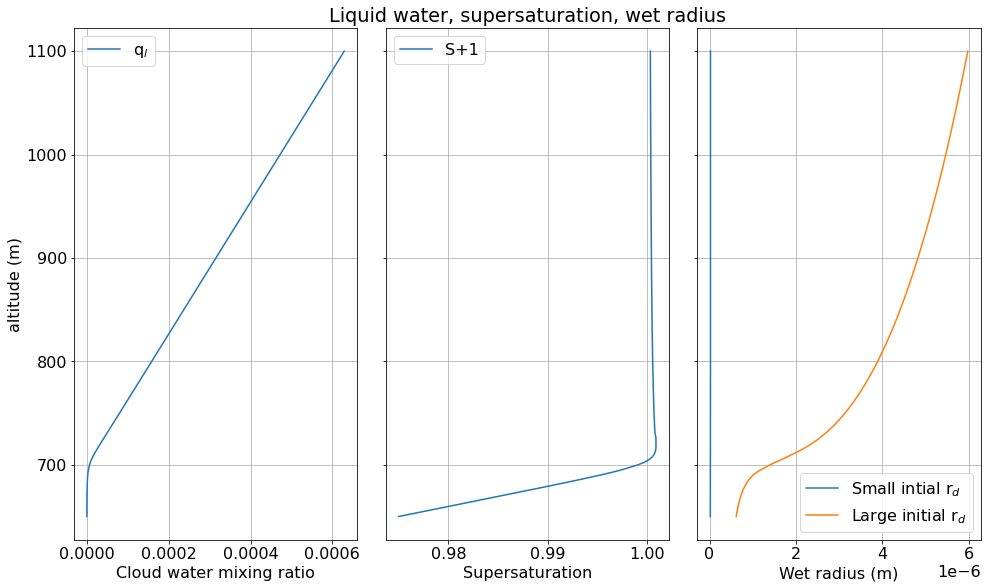

In [13]:
figsize = (14,9)
fig, ax = plt.subplots(1, 3, sharey=True, figsize=figsize)
ax = np.array(ax).reshape(1, 3)

for i, output in enumerate(outputs):
        
    ax[i,1].set_title('Liquid water, supersaturation, wet radius')
    ax[i, 0].set_ylabel("altitude (m)")

    # ax[i,0].set_ylim([800, 1050])
    ax[i,0].plot(output['q'], output['z'], label="q$_l$")
    ax[i,0].xaxis.set_units(si.gram / si.kilogram)
    ax[i,0].grid()
    ax[i,0].legend(loc='best')
    ax[i,0].set_xlabel("Cloud water mixing ratio")


    ax[i,1].plot(output['S']+1, output['z'], label="S+1")
    ax[i,1].grid()
    ax[i,1].set_xlabel("Supersaturation")

    ax[i,1].legend(loc='best')
   # ax[i,1].set_xlim([0.993, 1.003])

    ax[i,2].plot(output['r'][40], output['z'], label="Small intial r$_d$")
    ax[i,2].plot(output['r'][8000], output['z'], label="Large initial r$_d$")
    ax[i,2].grid()
    ax[i,2].xaxis.set_units(si.micrometre)
    ax[i,2].legend(loc='best')
    ax[i,2].set_xlabel("Wet radius (m)")

    plt.tight_layout()
    fig.subplots_adjust(top=0.88)
    
show_plot(filename='q_S_rd.pdf')

In [ ]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=figsize)
ax = (ax,)

for i, output in enumerate(outputs):
    
    hist = output['r_bins_values']
    hist = (hist[:,0:-1] + hist[:,1:])/2
    xedges = np.array(output['t']) / 60.
    yedges = np.array(output['r_bins_edges']) * 1e6

    c = ax[i].pcolormesh(
        xedges, 
        yedges, 
        hist,
        cmap = 'coolwarm', shading='auto',
        norm = mpl.colors.LogNorm()
    )
    
    ax[i].set_title('Size distribution evolution')
    ax[i].set_xlabel("time [s]")
    ax[i].set_ylabel("wet radius [um]")
    
    ax[i].set_ylim([0, 8])

    ax[i].legend(loc='best')
    ax[i].grid()
    plt.tight_layout()
    fig.subplots_adjust(top=0.88)
    
show_plot(filename='spectrum.pdf')

0.7200000000000001


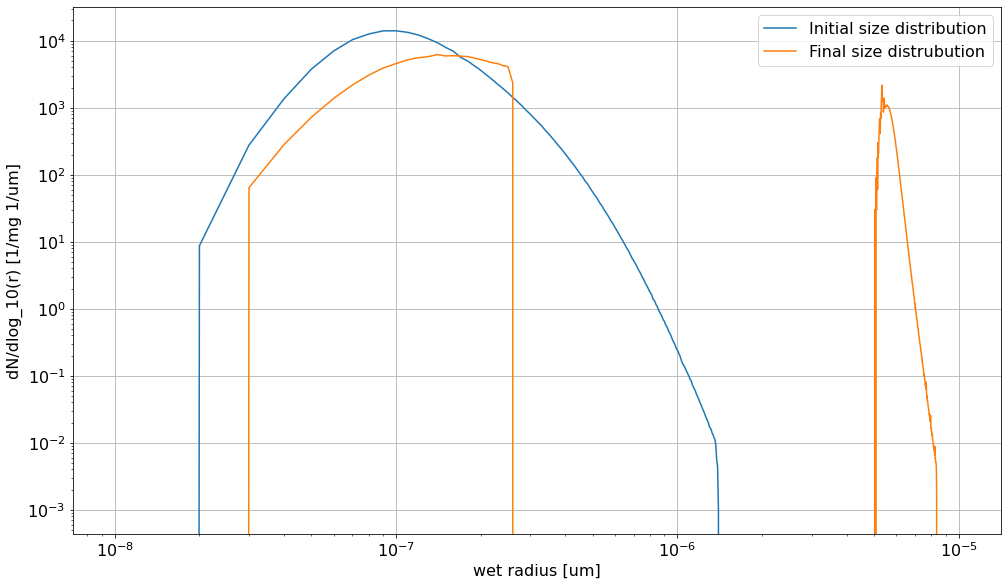

In [23]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=figsize)
ax = (ax,)

for i, output in enumerate([outputs[17]]):
    print(r_factors[17])

    xunit = si.micrometres
    
    hist = output['r_bins_values']
    hist_init = (hist[:,0:-1] + hist[:,1:])/2
    edges = output['r_bins_edges']
    

    ax[i].plot(edges[1:], hist_init[:, -0], label="Initial size distribution")
    ax[i].plot(edges[1:], hist_init[:, -1], label="Final size distrubution")
    
    # ax[i].set_title('Wet radius size distribution')
    #ax[i].xaxis.set_units(xunit)
    #ax[i].set_xlim([2e-2, 10])
    #ax[i].set_ylim([1, 2*1e4])

    plt.xscale("log")
    plt.yscale("log")  
    
    ax[i].legend(loc='best')
    ax[i].grid()
    plt.tight_layout()
    
    ax[i].set_xlabel("wet radius [um]")
    ax[i].set_ylabel("dN/dlog_10(r) [1/mg 1/um]")
    
    fig.subplots_adjust(top=0.88)
    
show_plot(filename='Initial_and_final_size_distribution.pdf')

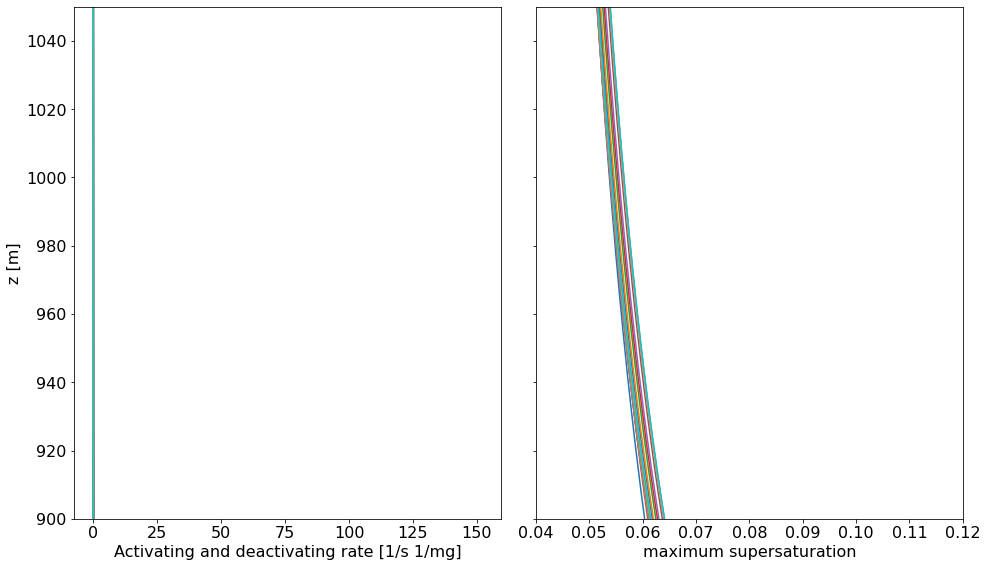

In [14]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=figsize)

for i, output in enumerate(outputs):

    yunit = si.metres
            
    ax[0].plot(output['activating_rate'], output['z'])
    ax[0].plot(output['deactivating_rate'], output['z'])
    
    ax[0].grid()
    ax[0].set_xlabel("Activating and deactivating rate [1/s 1/mg]")
    ax[0].set_ylabel("z [m]")
    ax[0].set_ylim([900, 1050])

    
    ax[1].plot(output['peak_S'], output['z'])
    
    ax[1].grid()
    ax[1].set_xlabel("maximum supersaturation")
    ax[1].set_xlim([0.04, 0.12])

    
    
    plt.tight_layout()
    fig.subplots_adjust(top=0.88)
    
show_plot(filename='Activating_rate.pdf')

In [ ]:
total_act = np.sum(output["activating_rate"]) * output["dt_output"]
total_deact = np.sum(output["deactivating_rate"]) * output["dt_output"]

N_act = total_act - total_deact

print("N_act = ", N_act)
print("S_max = ", np.nanmax(np.array(output["peak_S"])))